In [ ]:
# Import some required packages
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from textblob import TextBlob
from nltk.corpus import stopwords

import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import opinion_lexicon

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Load the list of stopwords from NLTK
stop_words = set(stopwords.words('english'))

In [ ]:
def count_distinct_values(df):
    """
    This function takes a DataFrame as input and returns a dictionary
    with the column names as keys and the number of distinct values as values.
    """
    distinct_counts = {}
    for column in df.columns:
        distinct_counts[column] = df[column].nunique()
    return distinct_counts

def preprocess_text(text):
    """
    Preprocess a single text entry by converting it to lowercase, removing non-alphanumeric characters,
    removing stopwords, and applying lemmatization.

    Args:
        text (str): The input text to preprocess.

    Returns:
        str: The preprocessed text.
    """

    # Remove non-alphanumeric characters (keeping spaces)
    text = re.sub(r'[^a-z0-9\s]', '', text)

    # Remove extra spaces
    text = text.strip()

    # Remove numbers (optional)
    text = re.sub(r'\d+', '', text)

    # Convert text to lowercase
    text = text.lower()

    # Tokenize, remove stopwords, and lemmatize
    words = text.split()
    words = [word for word in words if word not in stop_words]

    # Join words back into a single string
    text = ' '.join(words)

    return text


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
books = pd.read_csv('/content/books.csv')

Mounted at /content/drive


# 1. Understand the Dataset


Ok, first things first, let’s take a quick taste of the dataset, just like having a little nibble of your favorite snack before the main course!

We'll use some classic functions like .head(), .info(), and .describe() to give us a sneak preview. We’ll check out the types of variables (numerical, categorical, and text), spot any missing values, and figure out the best way to handle them—kind of like deciding what toppings to add to your pizza!

In [ ]:
books.head()

,title,price,review/helpfulness,review/summary,review/text,description,authors,categories,popularity
0,We Band of Angels: The Untold Story of America...,10.88,2/3,A Great Book about women in WWII,I have alway been a fan of fiction books set i...,"In the fall of 1941, the Philippines was a gar...",'Elizabeth Norman','History',Unpopular
1,Prayer That Brings Revival: Interceding for Go...,9.35,0/0,Very helpful book for church prayer groups and...,Very helpful book to give you a better prayer ...,"In Prayer That Brings Revival, best-selling au...",'Yong-gi Cho','Religion',Unpopular
2,The Mystical Journey from Jesus to Christ,24.95,17/19,Universal Spiritual Awakening Guide With Some ...,The message of this book is to find yourself a...,THE MYSTICAL JOURNEY FROM JESUS TO CHRIST Disc...,'Muata Ashby',"'Body, Mind & Spirit'",Unpopular
3,Death Row,7.99,0/1,Ben Kincaid tries to stop an execution.,The hero of William Bernhardt's Ben Kincaid no...,"Upon receiving his execution date, one of the ...",'Lynden Harris','Social Science',Unpopular
4,Sound and Form in Modern Poetry: Second Editio...,32.50,18/20,good introduction to modern prosody,There's a lot in this book which the reader wi...,An updated and expanded version of a classic a...,"'Harvey Seymour Gross', 'Robert McDowell'",'Poetry',Unpopular


In [ ]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15719 entries, 0 to 15718
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               15719 non-null  object 
 1   price               15719 non-null  float64
 2   review/helpfulness  15719 non-null  object 
 3   review/summary      15718 non-null  object 
 4   review/text         15719 non-null  object 
 5   description         15719 non-null  object 
 6   authors             15719 non-null  object 
 7   categories          15719 non-null  object 
 8   popularity          15719 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.1+ MB


The dataset contains 15,719 entries and 9 columns. Most columns are complete, but we have 1 missing value in the "review/summary" column. The data types are mostly text (object), with the price being the only numerical (float64) column. No significant missing data issues aside from that one review summary!

In [ ]:
books['price'].describe()

,price
count,15719.000000
mean,15.862783
std,8.464523
min,1.000000
25%,10.190000
50%,13.570000
75%,19.950000
max,41.770000


In [ ]:
# Check for missing values
missing_values = books.isnull().sum()
print('Missigng values')
print(missing_values)

Missigng values
title                 0
price                 0
review/helpfulness    0
review/summary        1
review/text           0
description           0
authors               0
categories            0
popularity            0
dtype: int64


# 2. Exploratory Data Analysis (EDA) and Feature Engineering - Uncovering Patterns and Building Meaningful Features


In this chapter, we’ll dive deeper into patterns, distributions, and relationships within the dataset using visualizations and summary statistics, which is the essence of EDA. Then, we'll move on to feature engineering, creating new and meaningful features to enhance our model's performance. This combined exploration and feature creation sets the stage for building a strong predictive model!

One thing I like to do early on, especially with not-so-huge datasets like this one, is to quickly check how many distinct values are inside each column. This is super helpful in spotting things like binary columns that might need fixing if something's off. We'll skip the columns with text like title, summary, text, and description because, of course, we expect each entry there to be unique!

In [ ]:
# Adjusting the function to only select the relevant columns without dropping them
selected_columns = books[['price', 'authors', 'categories', 'popularity']]

# Applying the distinct count function again
distinct_value_counts = count_distinct_values(selected_columns)

distinct_value_counts

{'price': 1600, 'authors': 6447, 'categories': 313, 'popularity': 2}

To our relief, the popularity column is indeed binary, so no further actions are needed there! However, when it comes to authors and categories, we see that they have a large number of distinct values (6447 and 313, respectively). This is where we’ll need to make some important decisions, like whether to group similar categories or apply techniques such as encoding to handle these features effectively.

A. **Target Variable Analysis** (Popularity) ✅

Let’s visualize the distribution of our target variable, popularity, to see how well-balanced the 'popular' and 'unpopular' classes are. This will help us understand if our dataset is imbalanced, which could affect the model's performance.

<ipython-input-10-bee7c6f2c86a>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=books, x='popularity', palette='coolwarm')


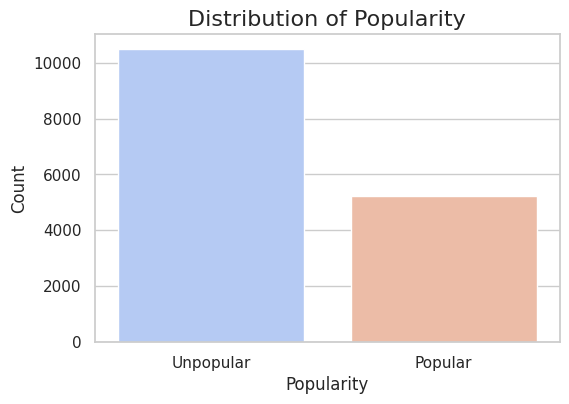

In [ ]:
# Set a theme for the chart
sns.set_theme(style="whitegrid")

# Create a countplot with some extra styling
plt.figure(figsize=(6, 4))
sns.countplot(data=books, x='popularity', palette='coolwarm')

# Add titles and labels
plt.title('Distribution of Popularity', fontsize=16)
plt.xlabel('Popularity', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Show the plotText
plt.show()

In [ ]:
# Count the number of samples in each class
class_distribution = books['popularity'].value_counts()

# Print the distribution
print(class_distribution)

popularity
Unpopular    10490
Popular       5229
Name: count, dtype: int64


This means that approximately two-thirds of the books are labeled as unpopular, while one-third are labeled as popular. While this isn't extremely imbalanced, there is a noticeable difference between the two classes, which is something to keep in mind for modeling. ​

B. **Feature Analysis**

- Feature **price** :

Now, let’s check out the numerical features! We'll look at the distribution of price to spot any patterns or outliers. Then, we’ll explore how price relates to popularity—maybe pricier books are more likely to be popular? Box plots and scatter plots will help us uncover any trends!


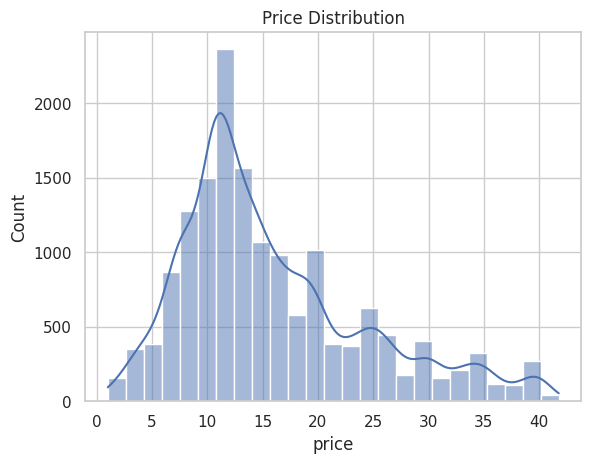

In [ ]:
# Numerical Features: Price
sns.histplot(books['price'], bins = 25, kde=True)
plt.title('Price Distribution')
plt.show()

The price distribution shows that most books are priced on the lower end, with fewer books in the higher price ranges. It seems people tend to prefer more affordable books—perhaps because not only buying but also storing can become a trouble!

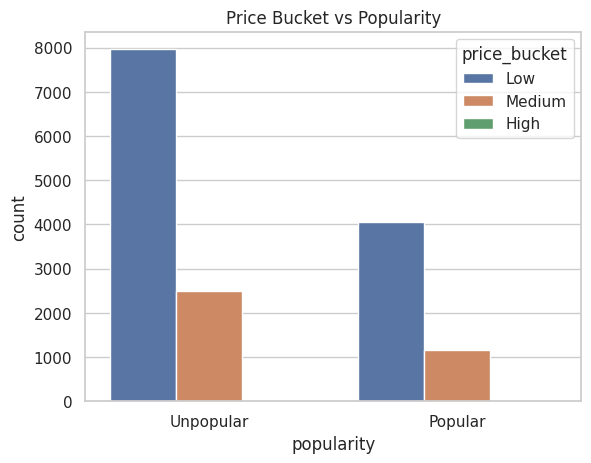

popularity,Popular,Unpopular
price_bucket,,
Low,4061,7964
Medium,1155,2494
High,13,32


In [ ]:
# Create Price Buckets
books['price_bucket'] = pd.cut(books['price'], bins=[0, 20, 40, np.inf], labels=[ 'Low', 'Medium', 'High'])

# Visualizing the count of popularity within each price bucket
sns.countplot(x='popularity', hue='price_bucket', data=books)
plt.title('Price Bucket vs Popularity')
plt.show()

# Counting the samples in each price bucket and popularity category with observed=False
price_popularity_counts = books.groupby(['price_bucket', 'popularity'], observed=False).size().unstack()

price_popularity_counts

It seems most books fall in the lower price category, and these books are more likely to be popular. Higher-priced books, as expected, are much rarer and less popular.

- Feature **review/helpfulness** :

Next, let’s explore the **review/helpfulness** feature! Even though it's currently in an object format, we can convert it into meaningful numerical features. Two useful features we can create are:
- the number of reviews a book receives and
- the percentage of helpful reviews.

These will help us understand how review quality and quantity may impact a book's popularity

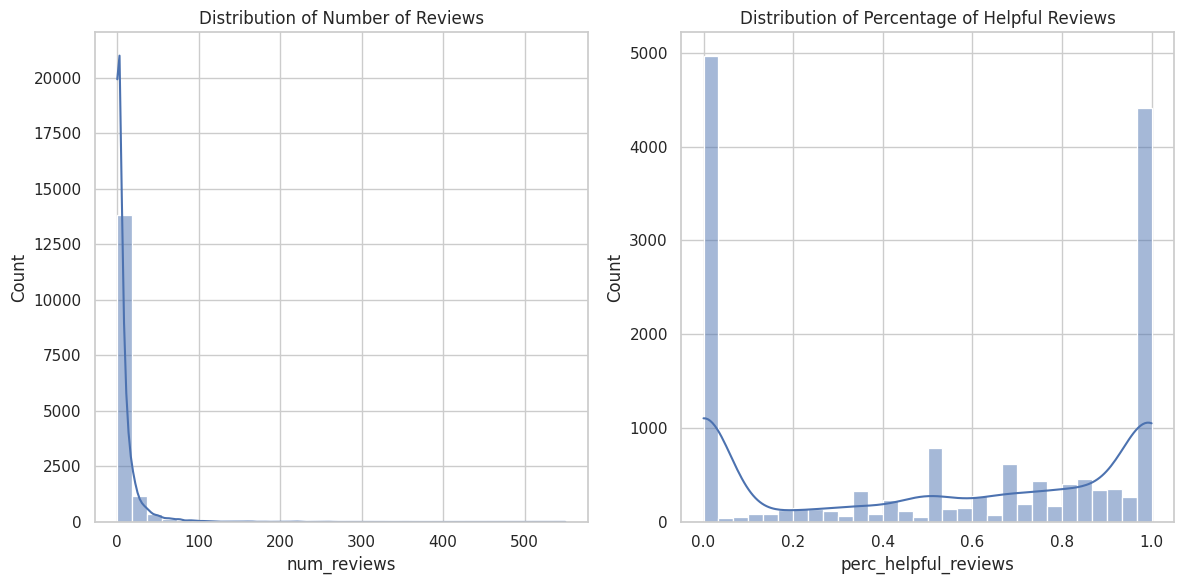

,num_reviews,perc_helpful_reviews
count,15719.000000,15719.000000
mean,8.943190,0.526126
std,21.471987,0.418837
min,0.000000,0.000000
25%,0.000000,0.000000
50%,3.000000,0.607477
75%,9.000000,1.000000
max,550.000000,1.000000


In [ ]:
# Calculate the total review counts per book and the number of helpful reviews
books['num_reviews'] = books['review/helpfulness'].str.split('/', expand=True)[1].astype(int)
books['num_helpful'] = books['review/helpfulness'].str.split('/', expand=True)[0].astype(int)

# Add percentage of helpful reviews as a column to normalize the data
books["perc_helpful_reviews"] = books["num_helpful"] / books["num_reviews"]

# Fill null values
books["perc_helpful_reviews"].fillna(0, inplace=True)

# Set up the figure
plt.figure(figsize=(12, 6))

# Plot 1: Distribution of number of reviews
plt.subplot(1, 2, 1)
sns.histplot(books['num_reviews'], bins=30, kde=True)
plt.title('Distribution of Number of Reviews')

# Plot 2: Distribution of percentage of helpful reviews
plt.subplot(1, 2, 2)
sns.histplot(books['perc_helpful_reviews'], bins=30, kde=True)
plt.title('Distribution of Percentage of Helpful Reviews')

# Show the plots
plt.tight_layout()
plt.show()

# Recalculate the descriptive statistics after filling missing values
review_stats_updated = books[['num_reviews', 'perc_helpful_reviews']].describe()

review_stats_updated

num_reviews: On average, books received about 8.94 reviews, with some books getting as many as 550. Half of the books have 3 or fewer reviews, showing a right-skewed distribution.
perc_helpful_reviews: The average percentage of helpful reviews is 52.6%. Interestingly, 50% of the books have over 60.7% helpful reviews, and 75% have fully helpful reviews, indicating that many books have high-quality reviews.


- Feature **categories** :

Next, we calculate the frequency of each book category to understand which categories appear most often. We visualize the top 20 categories by their frequency, giving us a clear picture of which genres or categories dominate the dataset. Next, we compute the cumulative distribution of all categories and plot it, which helps us understand how quickly the categories add up to cover a large percentage of the dataset.

<ipython-input-15-702840d9a99b>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_count.index[:20], y=category_count.values[:20], palette='viridis')


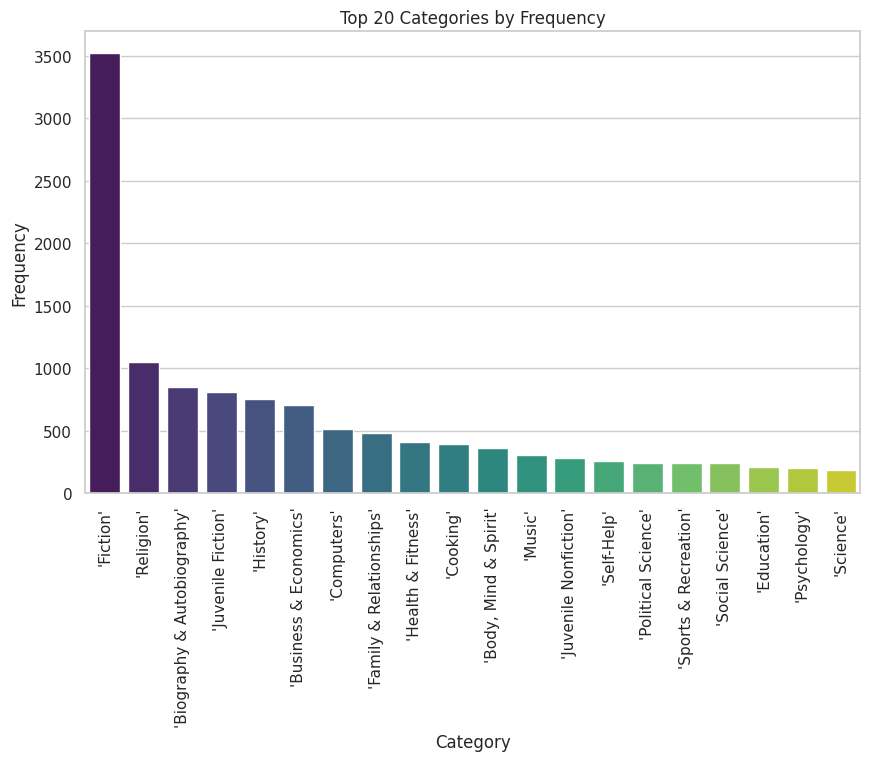

In [ ]:
# Visualize Category Frequencies

# Calculate the frequency of each category
category_count = books['categories'].value_counts()

# Visualize the frequency of each category
plt.figure(figsize=(10,6))
sns.barplot(x=category_count.index[:20], y=category_count.values[:20], palette='viridis')
plt.xticks(rotation=90)
plt.title('Top 20 Categories by Frequency')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.show()

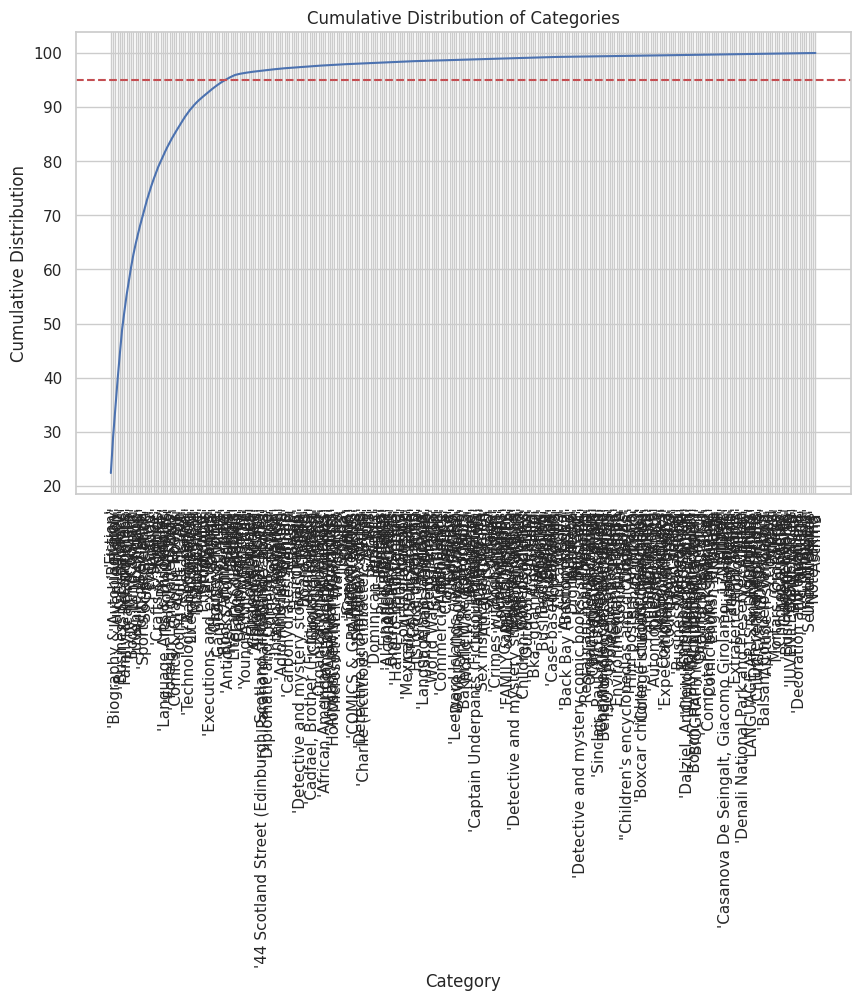

In [ ]:
# Calculate the cumulative distribution of categories
category_cumulative = category_count.cumsum() / category_count.sum() * 100

# Plot cumulative distribution
plt.figure(figsize=(10,6))
sns.lineplot(x=category_count.index, y = category_cumulative)
plt.xticks(rotation = 90)
plt.title('Cumulative Distribution of Categories')
plt.xlabel('Category')
plt.ylabel('Cumulative Distribution')
plt.axhline(y=95, color='r', linestyle='--')  # Example: threshold at 95%
plt.show()

From the results, we can see that a few categories are much more frequent than others, dominating the distribution. In the cumulative distribution plot, it becomes evident that a small number of categories make up a large portion of the dataset. For example, the top categories reach 95% of the data quite quickly, indicating that most books fall into a few key genres or categories. This suggests that focusing on these top categories could provide meaningful insights, while less frequent categories might be grouped or analyzed separately.

Next, we notice that some categories overlap or can be grouped into broader, higher-level categories. This step helps us reduce the total number of categories, making it more manageable for tasks like vectorization using techniques such as OneHot encoding. To achieve this, we take a straightforward approach: first, we review the unique categories, and then we map them into broader groups like Fiction, Non-fiction, and Science & Technology. Using a dictionary for this mapping ensures scalability and flexibility. Any smaller or less clear categories can be grouped under 'Other', keeping the dataset clean and organized!

<ipython-input-17-0a15a2fc5089>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=grouped_category_count.index, y=grouped_category_count.values, palette='coolwarm')


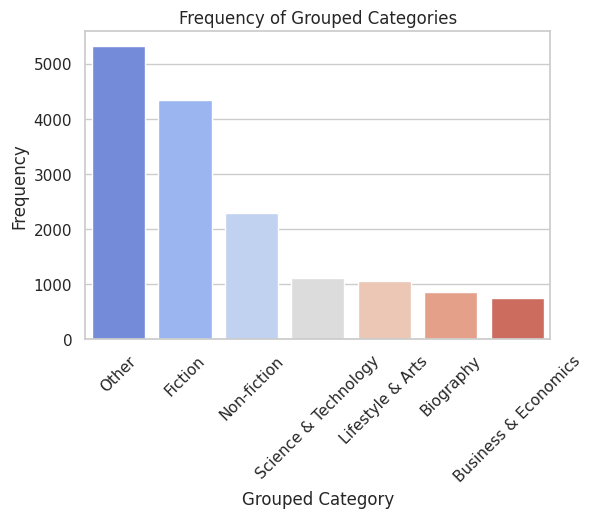

In [ ]:
# Define a dictionary for category mapping
category_mapping = {
    'Fiction': 'Fiction',
    'Juvenile Fiction': 'Fiction',
    'History': 'Non-fiction',
    'Religion': 'Non-fiction',
    'Social Science': 'Non-fiction',
    'Political Science': 'Non-fiction',
    'Science': 'Science & Technology',
    'Computers': 'Science & Technology',
    'Health & Fitness': 'Science & Technology',
    'Biography & Autobiography': 'Biography',
    'Business & Economics': 'Business & Economics',
    'Antiques & Collectibles': 'Business & Economics',
    'Music': 'Lifestyle & Arts',
    'Poetry': 'Lifestyle & Arts',
    'Nature': 'Lifestyle & Arts',
    'Travel': 'Lifestyle & Arts',
    'Pets': 'Lifestyle & Arts',
    'Self-Help': 'Lifestyle & Arts'
}

# Function to group categories using the dictionary
def map_category_to_group(category):
    category = category.strip("'")  # Remove any extra quotation marks
    return category_mapping.get(category, 'Other')  # Use 'Other' if category not in mapping

# Apply the mapping function to the 'categories' column
books['grouped_category'] = books['categories'].apply(map_category_to_group)

# Visualize Grouped Categories

# Calculate the frequency of each grouped category
grouped_category_count = books['grouped_category'].value_counts()

# Plot the frequency of each grouped category
plt.figure(figsize=(6, 4))
sns.barplot(x=grouped_category_count.index, y=grouped_category_count.values, palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Frequency of Grouped Categories')
plt.xlabel('Grouped Category')
plt.ylabel('Frequency')
plt.show()

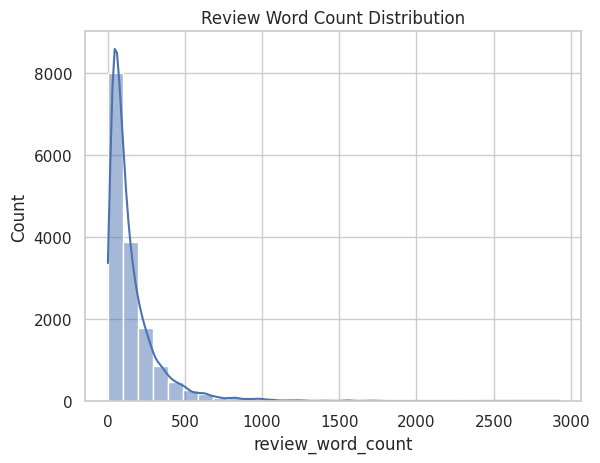

In [ ]:
# Word Count in Reviews
books['review_word_count'] = books['review/text'].apply(lambda x: len(str(x).split()))
sns.histplot(books['review_word_count'], bins=30, kde=True)
plt.title('Review Word Count Distribution')
plt.show()

#books.drop(columns=['review_word_count'], inplace=True)

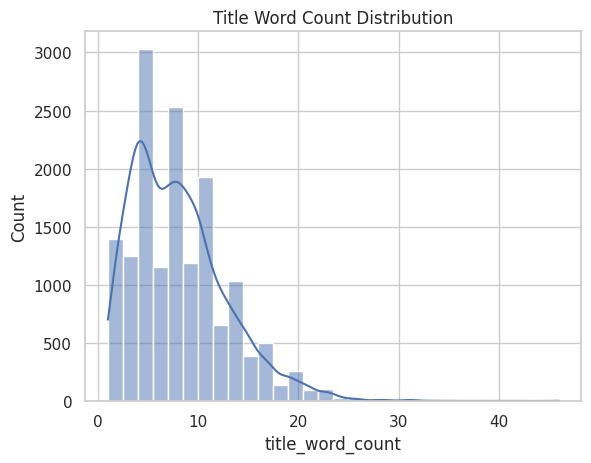

In [ ]:
# Word Count in Titles
books['title_word_count'] = books['title'].apply(lambda x: len(str(x).split()))
sns.histplot(books['title_word_count'], bins=30, kde=True)
plt.title('Title Word Count Distribution')
plt.show()

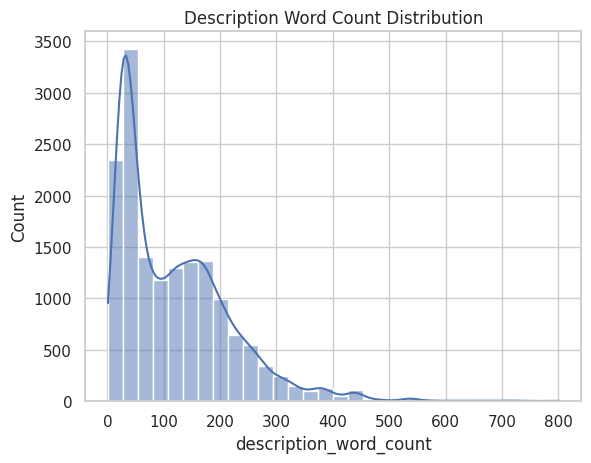

In [ ]:
# Word Count in Description
books['description_word_count'] = books['description'].apply(lambda x: len(str(x).split()))
sns.histplot(books['description_word_count'], bins=30, kde=True)
plt.title('Description Word Count Distribution')
plt.show()

- Features: **review/summary** and **review/text**

Next, moving to the text features about reviews (specifically the summary and text), we’re exploring new features we can extract. For example, could the sentiment of a review influence whether a book becomes popular or not? To investigate this, we first clean up the review text and then use TextBlob to calculate sentiment scores, ranging from -1 (negative) to 1 (positive). Afterward, we visualize these sentiment scores to see if any patterns emerge that could help us understand their potential impact on popularity.

In [ ]:
# Apply text preprocessing function to columns with text reviews
text_columns = ['review/text', 'review/summary', 'description']

# Replace NaN values with empty strings
books[text_columns] = books[text_columns].fillna('')

# Apply the preprocessing function to each column
for col in text_columns:
  books[col] = books[col].apply(preprocess_text)

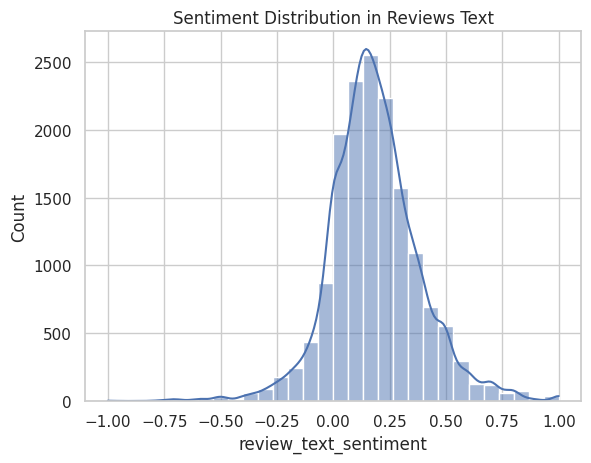

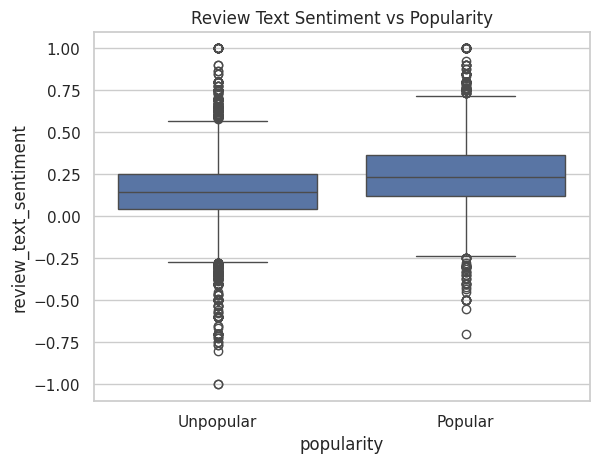

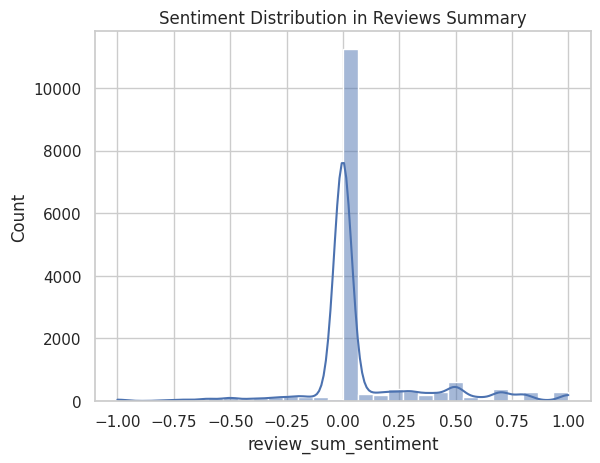

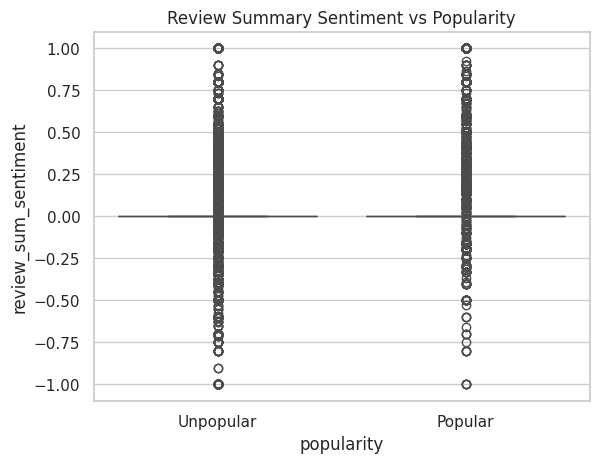

In [ ]:
# Sentiment Analysis on reviews text
books['review_text_sentiment'] = books['review/text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
sns.histplot(books['review_text_sentiment'], bins=30, kde=True)
plt.title('Sentiment Distribution in Reviews Text')
plt.show()

# Relationship between Sentiment and Popularity
sns.boxplot(x='popularity', y='review_text_sentiment', data=books)
plt.title('Review Text Sentiment vs Popularity')
plt.show()

# Sentiment Analysis on reviews summary
books['review_sum_sentiment'] = books['review/summary'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
sns.histplot(books['review_sum_sentiment'], bins=30, kde=True)
plt.title('Sentiment Distribution in Reviews Summary')
plt.show()

# Relationship between Sentiment and Popularity
sns.boxplot(x='popularity', y='review_sum_sentiment', data=books)
plt.title('Review Summary Sentiment vs Popularity')
plt.show()

Reviews text sentiment:

- Distribution: The sentiment scores are mostly centered around neutral (0), with both positive and negative reviews, though more reviews lean toward positive sentiments.

- Review Text Sentiment vs. Popularity: The box plot shows that there is a slight tendency for more positive sentiment in popular books. However, the difference is not dramatic, suggesting that while sentiment might influence popularity, it’s not a strong determining factor.

Reviews summary sentiment:

- Distribution: Similar to the full text, the review summaries also show a mix of positive and negative sentiments, with a majority clustering around neutral or slightly positive.

- Review Summary Sentiment vs. Popularity: Again, there's a slight bias towards higher sentiment in popular books, but the overall difference between popular and unpopular books is small.

**3. Data Cleaning**

In [ ]:
# Convert popularity to numerical values (1 for Popular, 0 for Unpopular)
books['popularity'] = books['popularity'].apply(lambda x: 1 if x == 'Popular' else 0)

In [ ]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15719 entries, 0 to 15718
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   title                   15719 non-null  object  
 1   price                   15719 non-null  float64 
 2   review/helpfulness      15719 non-null  object  
 3   review/summary          15719 non-null  object  
 4   review/text             15719 non-null  object  
 5   description             15719 non-null  object  
 6   authors                 15719 non-null  object  
 7   categories              15719 non-null  object  
 8   popularity              15719 non-null  int64   
 9   price_bucket            15719 non-null  category
 10  num_reviews             15719 non-null  int64   
 11  num_helpful             15719 non-null  int64   
 12  perc_helpful_reviews    15719 non-null  float64 
 13  grouped_category        15719 non-null  object  
 14  review_word_count     

Next, we calculate the correlation matrix to see how different features relate to each other and to the target variable popularity. This helps us identify any strong relationships between variables, which can guide us in selecting the most useful features for our model.

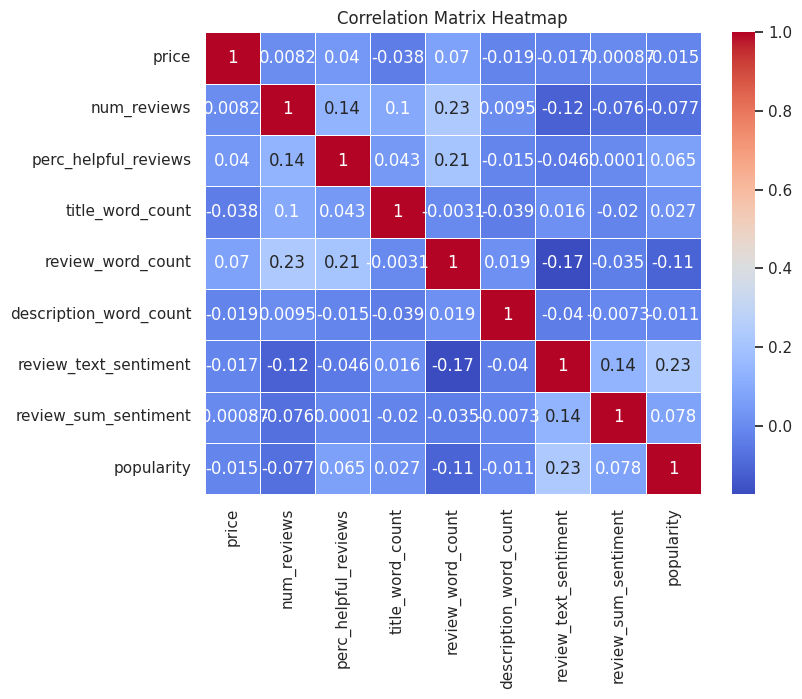

In [ ]:
# Calculate correlation matrix and display it here
correlation_matrix = books[['price', 'num_reviews', 'perc_helpful_reviews', 'title_word_count','review_word_count', 'description_word_count','review_text_sentiment', "review_sum_sentiment", "popularity"]].corr()

# Visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

Looking at the correlation matrix, we can see that review text sentiment has the strongest positive correlation with popularity (0.23), meaning more positive reviews tend to relate to a book being popular. Other features like review summary sentiment (0.08) and percentage of helpful reviews (0.07) also show a mild positive relationship with popularity. On the flip side, features like number of reviews and review word count show weak negative correlations with popularity, indicating that more reviews or longer reviews don’t necessarily mean a book will be more popular.

In the next step, we're enhancing our features by extracting positive sentiment features from the text using TF-IDF (Term Frequency-Inverse Document Frequency). Specifically, we use a pre-defined set of positive words from the NLTK opinion lexicon to focus on words that convey positive sentiment.

In [ ]:
text_columns = ['review/text', 'review/summary', 'description']

# Download the opinion lexicon from NLTK
nltk.download('opinion_lexicon')

# Get a list of positive words from the opinion lexicon
positive_words = set(opinion_lexicon.positive())

def extract_positive_sentiment_features(text_column, positive_words):
    """
    Extract positive sentiment features using TfidfVectorizer, limited to positive words.

    Args:
        text_column (pd.Series): The text column from the DataFrame.
        positive_words (set): A set of positive words to limit the vocabulary.

    Returns:
        pd.DataFrame: A DataFrame with TF-IDF scores for the positive words.
    """
    # Initialize TfidfVectorizer with the positive words as the vocabulary
    vectorizer = TfidfVectorizer(vocabulary=positive_words, stop_words='english')

    # Fit and transform the text column
    tfidf_matrix = vectorizer.fit_transform(text_column.fillna(''))

    # Convert the TF-IDF matrix to a DataFrame
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

    # Sum the TF-IDF scores across all positive words for each document
    tfidf_df['positive_sentiment_score'] = tfidf_df.sum(axis=1)

    return tfidf_df

# Extract positive sentiment features for each column
for col in text_columns:
    tfidf_df = extract_positive_sentiment_features(books[col], positive_words)

    # Add the positive sentiment score back to the original DataFrame
    books[f'positive_words_{col}'] = tfidf_df['positive_sentiment_score']

# Drop the original text columns if you don't need them anymore
books.drop(columns=text_columns, inplace=True)

[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


After creating the new positive sentiment score features using the TF-IDF approach, we’ll also calculate a correlation matrix to see how these new features relate to the target variable (popularity), similar to what we did before.

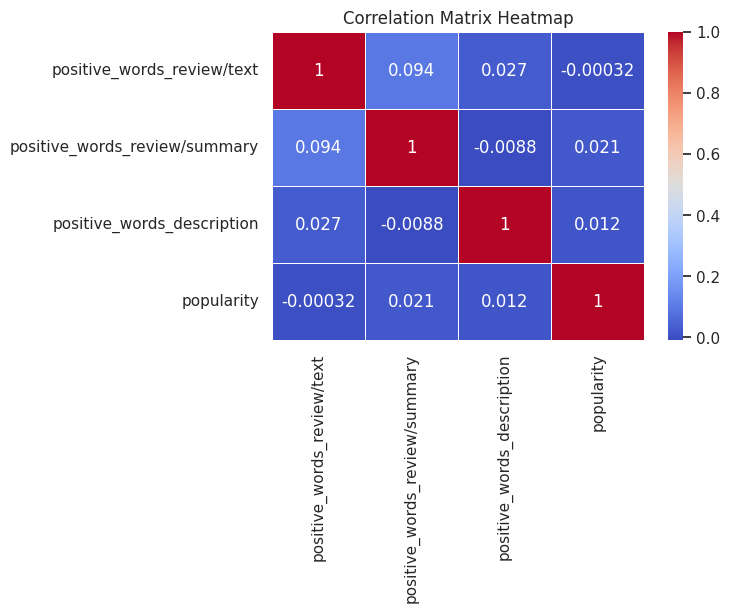

In [ ]:
# Calculate correlation matrix and display it here
correlation_matrix = books[['positive_words_review/text', 'positive_words_review/summary','positive_words_description', "popularity"]].corr()

# Visualize the correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

Unfortunately, after calculating the correlation matrix, we notice that the new positive sentiment score features show only a weak correlation with popularity.

Next, we’re using OneHot encoding to convert the 'grouped_category' column into multiple binary columns, each representing a category.  The encoded columns are then added back into the main dataset, and the original 'categories' and 'grouped_category' columns are dropped, as they are no longer needed. This prepares the categorical data for machine learning models by turning them into numerical values.

In [ ]:
# Perform OneHot encoding on the 'grouped_category' column
onehot_encoded_categories = pd.get_dummies(books['grouped_category'], prefix='category').astype(int)

# Incorporate the onehot encoded columns into the main dataset
books = pd.concat([books, onehot_encoded_categories], axis=1)

# Drop the original 'categories' and 'grouped_category' columns as they're no longer needed
books.drop(columns=['categories', 'grouped_category'], inplace=True)

In [ ]:
# Drop all columns that are of type object or string, as well as the 'popularity' column
X = books.select_dtypes(exclude=['object', 'category']).drop(columns=['popularity'])

# Display the resulting feature matrix X
X.head()

,price,num_reviews,num_helpful,perc_helpful_reviews,review_word_count,title_word_count,description_word_count,review_text_sentiment,review_sum_sentiment,positive_words_review/text,positive_words_review/summary,positive_words_description,category_Biography,category_Business & Economics,category_Fiction,category_Lifestyle & Arts,category_Non-fiction,category_Other,category_Science & Technology
0,10.88,3,2,0.666667,90,16,318,0.480000,0.00,1.682698,0.000000,3.147287,0,0,0,0,1,0,0
1,9.35,0,0,0.000000,23,15,74,0.550000,0.00,1.941314,1.000000,1.382405,0,0,0,0,1,0,0
2,24.95,19,17,0.894737,1174,7,94,-0.013056,0.00,3.738725,0.000000,1.000000,0,0,0,0,0,1,0
3,7.99,1,0,0.000000,370,2,142,0.096456,-0.10,3.776591,0.000000,1.858790,0,0,0,0,1,0,0
4,32.50,20,18,0.900000,341,11,13,0.156341,0.45,2.531669,1.362934,1.000000,0,0,0,1,0,0,0


In [ ]:
# Assign the target variable 'popularity' to y
y = books['popularity']

# 3. Feature Selection

In this chapter, we focus on **feature selection**—the process of identifying the most important features that contribute to our model’s success. Using a **Random Forest** model, we rank the features by their importance and highlight the top ones that play the biggest role in predicting whether a book will be popular. This helps us refine the model, making it both simpler and more efficient!

In [ ]:
# Train a Random Forest model to assess feature importance
rf = RandomForestClassifier(n_estimators=50)  # Initialize RandomForest with 50 trees
# Fit the model to the feature matrix X and target variable y
rf.fit(X, y)

# Extract the feature importances from the trained Random Forest model
importances = rf.feature_importances_

# Get the feature names from the X dataset
features = X.columns

# Combine the features and their importances
feature_importance = list(zip(features, importances))

# Sort features by importance in descending order
sorted_features = sorted(feature_importance, key=lambda x: x[1], reverse=True)

# Print the sorted top 10 features
print("\nTop 10 Important Features:")
for feature, importance in sorted_features[:10]:
    print(f"{feature}: {importance:.4f}")


Top 10 Important Features:
review_text_sentiment: 0.1478
review_word_count: 0.1146
positive_words_review/text: 0.1067
price: 0.1048
description_word_count: 0.0998
positive_words_description: 0.0857
title_word_count: 0.0736
perc_helpful_reviews: 0.0526
num_reviews: 0.0521
review_sum_sentiment: 0.0474


In [ ]:
# Assuming 'sorted_features' from the previous step already contains the important features sorted by importance
# Extract the names of the top 10 features
top_10_features = [feature for feature, _ in sorted_features[:10]]

# Create a new X with only the top 10 important features
X= X[top_10_features]

# 4. Model Training and Evaluation

This chapter focuses on splitting the data, training a Random Forest Classifier, and evaluating the model's performance by calculating its accuracy on both the training and test sets.

In [ ]:

# Splitting into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200],  # Different numbers of trees
    'max_depth': [25, 50],   # Different tree depths
}

# Instantiate the Random Forest Classifier
clf = RandomForestClassifier(min_samples_split=5, random_state=42, class_weight="balanced")

# Set up GridSearchCV to search over the parameter grid and include verbose=2 to print progress
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train.ravel())

# Print the best parameters found by the grid search
print(f"Best parameters: {grid_search.best_params_}")

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
print(f"Training accuracy: {best_model.score(X_train, y_train):.4f}")
print(f"Test accuracy: {best_model.score(X_test, y_test):.4f}")

# Store the final test accuracy in a variable
model_accuracy = best_model.score(X_test, y_test)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'max_depth': 50, 'n_estimators': 200}
Training accuracy: 0.9997
Test accuracy: 0.7364
